## 3. Linear Activation Function

$$
Z_L=\phi_L\left(B_L\cdot \tilde Z_{L-1} \right) \\
Z_L=\phi_L\left(B_L\cdot \phi_{L-1}\left(B_{L-1}\cdot \tilde Z_{L-2} \right) \right) \\
$$
Let $f_l: \mathbb R^{H_{l-1}}\rightarrow\mathbb R^{H_{l}}$ be the function that calculates the pre-activations: $Z_{l-1} \mapsto \tilde Z_l= B_l Z_{l-1}$ which is obviously a linear function. So the total function reads
$$
Z_L=\underbrace{\phi_L \circ f_L \circ \phi_{L-1} \circ f_{L-1} \circ \ldots \circ \phi_1 \circ f_1}_{=:\mathbf F} (Z_0)
$$
As the composition between two linear functions is still a linear function, $\mathbf F$ is also a linear function which can be written as a composition of two arbitrary linear functions $\tilde f,\tilde \phi$ so that $\mathbf F = \tilde\phi \circ \tilde f$.
$$\Rightarrow Z_L=\tilde\phi \circ \tilde f (Z_0)$$That means that a neural network with a linear activation function is equivalent to a 1-layer neural network.

## 4. Application

In [65]:
import numpy as np
from sklearn import datasets

####################################

class ReLULayer(object):
    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the ReLU of the input
        relu = input.copy()
        relu[np.where(input<0)]=0
        #np.max(np.hstack((input,np.zeros(len(input))))) # your code here
        return relu

    def backward(self, upstream_gradient):
        # compute the derivative of ReLU from upstream_gradient and the stored input
        grad_diag = np.ones(len(self.input))
        grad_diag[self.input < 0] = 0
        grad_diag = np.diag(grad_diag)
        return grad_diag @ upstream_gradient

    def update(self, learning_rate):
        pass # ReLU is parameter-free

####################################

class OutputLayer(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the softmax of the input
        softmax = np.exp(input)/np.sum(np.exp(input),axis=0) # your code here
        return softmax

    def backward(self, predicted_posteriors, true_labels):
        # return the loss derivative with respect to the stored inputs
        # (use cross-entropy loss and the chain rule for softmax,
        #  as derived in the lecture)
        #cross entropy loss=-np.log(np.choose(true_labels,predicted_posteriors.T)).mean()
        #but we only need the gradient
        #gradient
        grad=predicted_posteriors
        grad[true_labels]-=1
        downstream_gradient = grad
        return downstream_gradient

    def update(self, learning_rate):
        pass # softmax is parameter-free

####################################

class LinearLayer(object):
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs  = n_inputs
        self.n_outputs = n_outputs
        # randomly initialize weights and intercepts
        self.B = np.random.normal(size=(n_inputs,n_outputs)) # your code here
        self.b = np.random.normal(size=(n_outputs)) # your code here
        # initialize gradients
        self.grad_B = np.zeros_like(self.B)
        self.grad_b = np.zeros_like(self.b)

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # compute the scalar product of input and weights
        # (these are the preactivations for the subsequent non-linear layer)
        preactivations = input@self.B+self.b
        return preactivations

    def backward(self, upstream_gradient):
        # compute the derivative of the weights from
        # upstream_gradient and the stored input
        # TODO: check if true
        self.grad_b += upstream_gradient
        self.grad_B += np.outer(upstream_gradient, self.input.T).T

        # compute the downstream gradient to be passed to the preceding layer
        return self.B @ upstream_gradient

    def update(self, learning_rate):
        # update the weights by batch gradient descent
        self.B = self.B - learning_rate * self.grad_B
        self.b = self.b - learning_rate * self.grad_b
        #reset gradients
        self.grad_B = np.zeros_like(self.B)
        self.grad_b = np.zeros_like(self.b)


####################################

class MLP(object):
    def __init__(self, n_features, layer_sizes):
        # constuct a multi-layer perceptron
        # with ReLU activation in the hidden layers and softmax output
        # (i.e. it predicts the posterior probability of a classification problem)
        #
        # n_features: number of inputs
        # len(layer_size): number of layers
        # layer_size[k]: number of neurons in layer k
        # (specifically: layer_sizes[-1] is the number of classes)
        self.n_layers = len(layer_sizes)
        self.layer_sizes=layer_sizes
        self.layers   = []

        # create interior layers (linear + ReLU)
        n_in = n_features
        for n_out in layer_sizes[:-1]:
            self.layers.append(LinearLayer(n_in, n_out))
            self.layers.append(ReLULayer())
            n_in = n_out

        # create last linear layer + output layer
        n_out = layer_sizes[-1]
        self.layers.append(LinearLayer(n_in, n_out))
        self.layers.append(OutputLayer(n_out))

    def forward(self, X):
        # X is a mini-batch of instances
        batch_size = X.shape[0]
        # flatten the other dimensions of X (in case instances are images)
        #X = X.reshape(batch_size, -1)

        # compute the forward pass
        # (implicitly stores internal activations for later backpropagation)
        result = X
        for layer in self.layers:
            result = layer.forward(result)
        return result

    def backward(self, predicted_posteriors, true_classes):
        # perform backpropagation w.r.t. the prediction for the latest mini-batch X
        #first the gradient of the loss from the output layer
        grad = self.layers[-1].backward(predicted_posteriors,true_classes)
        # work back from the last layer
        for layer in self.layers[-2::-1]:
            grad=layer.backward(grad)
            

    def update(self, X, Y, learning_rate):
        posteriors = self.forward(X)
        self.backward(posteriors, Y)
        for layer in self.layers:
            layer.update(learning_rate)

    def train(self, x, y, n_epochs, batch_size, learning_rate):
        N = len(x)
        n_batches = N // batch_size
        for i in range(n_epochs):
            # print("Epoch", i)
            # reorder data for every epoch
            # (i.e. sample mini-batches without replacement)
            permutation = np.random.permutation(N)

            for batch in range(n_batches):
                # create mini-batch
                start = batch * batch_size
                x_batch = x[permutation[start:start+batch_size]]
                y_batch = y[permutation[start:start+batch_size]]

                # perform one forward and backward pass and update network parameters
                for j in range(len(y_batch)):
                    self.update(x_batch[j], y_batch[j], learning_rate)

In [51]:
# set training/test set size
N = 2000

# create training and test data
X_train, Y_train = datasets.make_moons(N, noise=0.05)
X_test,  Y_test  = datasets.make_moons(N, noise=0.05)
n_features = 2
n_classes  = 2

# standardize features to be in [-1, 1]
offset  = X_train.min(axis=0)
scaling = X_train.max(axis=0) - offset
X_train = ((X_train - offset) / scaling - 0.5) * 2.0
X_test  = ((X_test  - offset) / scaling - 0.5) * 2.0

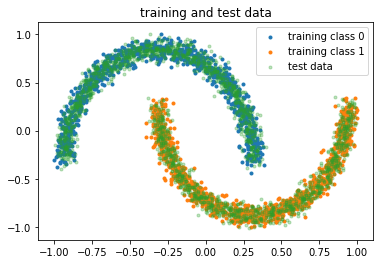

In [52]:
import matplotlib.pyplot as plt
for i in [0,1]:
    plt.scatter(*X_train[Y_train==i].T,label='training class %i'%i,marker='.')
plt.scatter(*X_test.T,label='test data',marker='.',alpha=.3)
plt.legend()
plt.title('training and test data')
plt.show()

In [53]:
# set hyperparameters (play with these!)
layer_sizes = [5,10, n_classes]
n_epochs = 7
batch_size = 20
learning_rate = 0.05

# create network
network = MLP(n_features, layer_sizes)

In [54]:
# train
network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

In [61]:
def validation_error(network,printOut=True):
    # test
    predicted_posteriors = network.forward(X_test)
    # determine class predictions from posteriors by winner-takes-all rule
    predicted_classes = np.argmax(predicted_posteriors,axis=1) # your code here
    # compute and output the error rate of predicted_classes
    error_rate = np.count_nonzero(predicted_classes!=Y_test)/len(Y_test) # your code here
    if printOut:
        print("error rate:", error_rate)
    return error_rate
validation_error(network)

error rate: 0.0


0.0

In [56]:
#create grid for displaying the decision line
x_gr,y_gr=np.linspace(min(X_train.T[0]),max(X_train.T[0]),200),np.linspace(min(X_train.T[1]),max(X_train.T[1]),200)
X,Y=np.meshgrid(x_gr,y_gr)
grid=np.vstack(map(np.ravel, np.meshgrid(x_gr,y_gr))).T

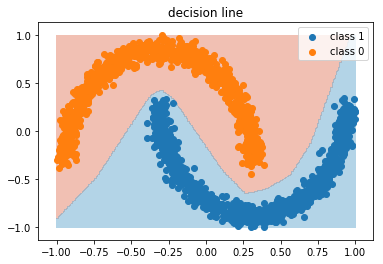

In [59]:
plt.contourf(X, Y,np.argmax(network.forward(grid),axis=1).reshape((200,200)) ,1,alpha=.5,cmap=plt.cm.RdBu)
plt.scatter(*np.transpose(X_train[Y_train==1]),label='class 1')
plt.scatter(*np.transpose(X_train[Y_train==0]),label='class 0')
plt.title('decision line')
plt.legend()

### Comparing the validation errors for different networks

In [78]:
layers=[[2,2,n_classes],
        [3,3,n_classes],
        [5,5,n_classes],
        [30,30,n_classes]]

In [81]:
def trainNTimes(n,layer_sizes):
    v=[]
    for i in range(n):
        x=MLP(n_features,layer_sizes)
        x.train(X_train, Y_train, n_epochs, batch_size, learning_rate)
        v.append(validation_error(x,False))
    return([np.mean(v),np.std(v)])

In [82]:
valErr=[]
for l in layers:
    valErr.append(trainNTimes(5,l))

In [89]:
for i in range(len(mlps)):
    print(mlps[i].layer_sizes,'\terror_rate: %.2f +/- %.2f'%(*valErr[i],))

[2, 2, 2] 	error_rate: 0.22 +/- 0.14
[3, 3, 2] 	error_rate: 0.18 +/- 0.16
[5, 5, 2] 	error_rate: 0.04 +/- 0.08
[30, 30, 2] 	error_rate: 0.00 +/- 0.00


The validation rates are decreasing with the amount of neurons in each layer. It won't be decreasing indefinetly as at some point the network will overfit to the training data but 30 neurons per layer seem to work fine.